In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import sys
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from embedding_layers import SkeletalInputEmbedding
from encoder_layers import TransformerEncoder
from decoder_layers import TransformerDecoder
import TF_helper_functions as hf
import pickle
import ipyvolume as ipv
import numpy as np
import ipywidgets as widgets
from IPython.display import display


In [2]:
datapath='/home/maleen/research_data/Transformers/datasets/khoa_datasets/'
# Base path and file information
base_name='24_08_29_training_norm'

weights_path='/home/maleen/research_data/Transformers/models/TF_tokenised/24_08_29_v1_best_model.pth'

filename=datapath+base_name+'.pkl'

datasetnum=1


def load_results_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def process_all_datasets(results, input_length=60, predict_length=60):
    all_X_pos, all_X_vel, all_X_acc = [], [], []
    all_Y_pos, all_Y_vel, all_Y_acc = [], [], []
    discarded_frames = {}

    for i in range(1, datasetnum+1):  # Assuming you have 6 datasets
        dataset_key = f'dataset{i}'
        norm_pos = results[f'{dataset_key}_normpos']
        norm_vel = results[f'{dataset_key}_normvel']
        norm_acc = results[f'{dataset_key}_normacc']

        # Generate sequences for this dataset
        X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc = hf.generate_sequences(norm_pos, norm_vel, norm_acc, input_length, predict_length)
        
        all_X_pos.append(X_pos)
        all_X_vel.append(X_vel)
        all_X_acc.append(X_acc)
        all_Y_pos.append(Y_pos)
        all_Y_vel.append(Y_vel)
        all_Y_acc.append(Y_acc)

        # Calculate discarded frames
        total_frames = norm_pos.shape[0]
        used_frames = X_pos.shape[0] + input_length + predict_length - 1
        discarded = total_frames - used_frames
        discarded_frames[dataset_key] = discarded

    # Combine sequences from all datasets
    combined_X_pos = np.concatenate(all_X_pos)
    combined_X_vel = np.concatenate(all_X_vel)
    combined_X_acc = np.concatenate(all_X_acc)
    combined_Y_pos = np.concatenate(all_Y_pos)
    combined_Y_vel = np.concatenate(all_Y_vel)
    combined_Y_acc = np.concatenate(all_Y_acc)

    return (combined_X_pos, combined_X_vel, combined_X_acc, 
            combined_Y_pos, combined_Y_vel, combined_Y_acc, 
            discarded_frames)




In [3]:
input_length = 15
predict_length = 30

# Load the results
results = load_results_from_pickle(filename)

medians_pos = results['combined_medians_pos']
iqrs_pos = results['combined_iqrs_pos']

medians_vel = results['combined_medians_vel']
iqrs_vel = results['combined_iqrs_vel']


# Process all datasets and get combined sequences
(combined_X_pos, combined_X_vel, combined_X_acc, 
 combined_Y_pos, combined_Y_vel, combined_Y_acc, 
 discarded_frames) = process_all_datasets(results, input_length, predict_length)

print("Combined sequences shapes:")
print(f"X_pos shape: {combined_X_pos.shape}")
print(f"X_vel shape: {combined_X_vel.shape}")
print(f"X_acc shape: {combined_X_acc.shape}")
print(f"Y_pos shape: {combined_Y_pos.shape}")
print(f"Y_vel shape: {combined_Y_vel.shape}")
print(f"Y_acc shape: {combined_Y_acc.shape}")

print("\nDiscarded frames per dataset:")
for dataset, frames in discarded_frames.items():
    print(f"{dataset}: {frames} frames")


Combined sequences shapes:
X_pos shape: (6700, 15, 6, 3)
X_vel shape: (6700, 15, 6, 3)
X_acc shape: (6700, 15, 6, 3)
Y_pos shape: (6700, 30, 6, 3)
Y_vel shape: (6700, 30, 6, 3)
Y_acc shape: (6700, 30, 6, 3)

Discarded frames per dataset:
dataset1: 0 frames


In [4]:
def robust_normalize_data_with_clipping(data, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]
            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(joint_axis_data, clipping_percentiles)
            # Clip the data based on thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)
            # Normalize the clipped data, avoiding division by zero
            if iqrs_per_joint_axis[joint, axis] > 0:
                normalized_values = (clipped_values - medians_per_joint_axis[joint, axis]) / iqrs_per_joint_axis[joint, axis]
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0
            # Store the normalized values
            normalized_data[:, joint, axis] = normalized_values
    return normalized_data

def calculate_combined_statistics(data_list):
    combined_data = np.concatenate(data_list, axis=0)
    medians = np.median(combined_data, axis=0)
    q75, q25 = np.percentile(combined_data, [75, 25], axis=0)
    iqrs = q75 - q25
    return medians, iqrs

def process_datasets_with_combined_normalization(datasets, timestamps_list):
    results = {}
    pos_list, vel_list, acc_list = [], [], []

    # First pass: calculate velocity and acceleration for each dataset
    for i, (dataset, timestamps) in enumerate(zip(datasets, timestamps_list), 1):
        pos, vel, acc = calculate_velocity_acceleration(dataset, timestamps)
        pos_list.append(pos)
        vel_list.append(vel)
        acc_list.append(acc)

    # Calculate combined statistics
    medians_pos, iqrs_pos = calculate_combined_statistics(pos_list)
    medians_vel, iqrs_vel = calculate_combined_statistics(vel_list)
    medians_acc, iqrs_acc = calculate_combined_statistics(acc_list)

    # Second pass: normalize each dataset using the combined statistics
    for i, (pos, vel, acc) in enumerate(zip(pos_list, vel_list, acc_list), 1):
        norm_pos = np.empty_like(pos)
        norm_vel = np.empty_like(vel)
        norm_acc = np.empty_like(acc)

        norm_pos = pos #robust_normalize_data_with_clipping(pos, medians_pos, iqrs_pos, norm_pos)
        norm_vel = robust_normalize_data_with_clipping(vel, medians_vel, iqrs_vel, norm_vel)
        norm_acc = robust_normalize_data_with_clipping(acc, medians_acc, iqrs_acc, norm_acc)

        results[f"dataset{i}_normpos"] = norm_pos
        results[f"dataset{i}_normvel"] = norm_vel
        results[f"dataset{i}_normacc"] = norm_acc

        print(f"Calculated and normalized for dataset{i}:")
        print(f"  Position shape: {norm_pos.shape}")
        print(f"  Velocity shape: {norm_vel.shape}")
        print(f"  Acceleration shape: {norm_acc.shape}")
        print()

    # Store the combined statistics
    results["combined_medians_pos"] = medians_pos
    results["combined_iqrs_pos"] = iqrs_pos
    results["combined_medians_vel"] = medians_vel
    results["combined_iqrs_vel"] = iqrs_vel
    results["combined_medians_acc"] = medians_acc
    results["combined_iqrs_acc"] = iqrs_acc

    return results

# Usage example

#results = process_datasets_with_combined_normalization(datasets, timestamps_list)

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model weights
checkpoint = torch.load(weights_path, map_location=device)
embed_dim = 128
num_heads = 8
num_layers = 6
num_joints = 6
dropout_rate = 0.1
autoregressiveloops=30
batch_size = 1
dof=3
input_dim = num_joints * dof

# Initialize the models with the same configuration as during training
embedding = SkeletalInputEmbedding(input_dim).to(device)
#t_embedding = TargetEmbedding(num_joints=num_joints, dof=3, embed_dim=embed_dim,device=device).to(device)
encoder = TransformerEncoder(embed_dim, num_heads, num_layers, dropout_rate).to(device)
decoder = TransformerDecoder(embed_dim, num_heads, num_layers, num_joints, dropout_rate).to(device)

# Load state dicts
embedding.load_state_dict(checkpoint['embedding_state_dict'])
#t_embedding.load_state_dict(checkpoint['t_embedding_state_dict'])
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

embedding.eval()
#t_embedding.eval()
encoder.eval()
decoder.eval()

# X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc = generate_sequences(norm_pos, norm_vel, norm_acc, input_length, predict_length)

# Convert to PyTorch tensors
X_pos_tensor = torch.tensor(combined_X_pos, dtype=torch.float32)
X_vel_tensor = torch.tensor(combined_X_vel, dtype=torch.float32)
X_acc_tensor = torch.tensor(combined_X_acc, dtype=torch.float32)


Y_pos_tensor = torch.tensor(combined_Y_pos, dtype=torch.float32)
Y_vel_tensor = torch.tensor(combined_Y_vel, dtype=torch.float32)
Y_acc_tensor = torch.tensor(combined_Y_acc, dtype=torch.float32)

# Create the DataLoader for inference data
dataset = TensorDataset(X_pos_tensor, X_vel_tensor, X_acc_tensor, Y_pos_tensor, Y_vel_tensor)
inference_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare for autoregressive decoding
#predicted_positions = []

criterion = hf.MaskedMSELoss()
batchnum=0
# Perform inference across all batches
for batch in inference_loader:
    X_pos_batch, X_vel_batch, X_acc_batch, Y_pos_batch, Y_vel_tensor = [b.to(device) for b in batch]
    
    predicted_positions = []



    # Encoder pass
   
    inputembeddings = embedding(X_pos_batch, X_vel_batch)
    memory = encoder(inputembeddings, src_key_padding_mask=None)

    
    # Initialize the start token for decoding
    current_pos = X_pos_batch[:, -1:, :, :]
    current_vel= X_vel_batch[:, -1:, :, :]


    for i in range(autoregressiveloops):
        # Embed the current position
        Y_expected= Y_pos_batch[:,i:i+1,:,:]
    

        # # #Running whole model
        # if i > 0:
        #     X_mask_batch_ar = torch.cat([X_mask_batch[:, 1:, :], current_mask], dim=1)
        #     X_pos_batch_ar = torch.cat([X_pos_batch[:, 1:, :, :], current_pos], dim=1)
    
        #     src_key_padding_mask = ~X_mask_batch_ar.view(batch_size, input_length * num_joints)
        #     input_embeddings = embedding(X_pos_batch_ar, X_mask_batch_ar)
        #     memory = encoder(input_embeddings, src_key_padding_mask=src_key_padding_mask)
        # ##
        
        current_embeddings = embedding(current_pos, current_vel)
        
        # Decoder pass
        output = decoder(current_embeddings, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None)
    
        # Update current_pos for the next prediction

        old_pos= current_pos
        current_pos = output[:, :, :, :].detach()  # only take the last timestep

        #current_vel = (current_pos-old_pos)/0.2

        # velocity_error=Y_vel_tensor[:, i, :, :]-current_vel
        # vel = Y_vel_tensor[:, i, :, :].cpu() 
        # norm_vel = np.empty_like(vel)
        # current_vel = robust_normalize_data_with_clipping(vel, medians_vel, iqrs_vel, norm_vel)
        # current_vel.gpu()
        
        current_vel = Y_vel_tensor[:, i, :, :]

        #
        # print('velocity_error: ', velocity_error)
    
        predicted_positions.append(current_pos.squeeze().cpu().numpy())

        
        output = output.where(~torch.isnan(output), torch.zeros_like(output))
        # masked_output = output * Xmask
    
        Y_expected = Y_expected.where(~torch.isnan(Y_expected), torch.zeros_like(Y_expected))
        # masked_y_pos = Y_pos_batch * Ymask

        #print(Y_expected)
    
        # Compute loss
        
        loss = criterion(output, Y_expected)

        
    
    batchnum=batchnum+1
    #print(batchnum)
    #break

    if batchnum == 100:
        print('broke ', batchnum )
        print(loss)
        break
# Convert the list of predicted positions to a more manageable form, e.g., a NumPy array
predicted_positions = np.array(predicted_positions)

print("Predicted Positions:", predicted_positions)


broke  100
tensor(0.1098, device='cuda:0', grad_fn=<MeanBackward0>)
Predicted Positions: [[[ 0.58795035 -0.516806   -0.83223724]
  [ 0.30071968 -0.7724182  -0.48497933]
  [-0.375444   -0.32047167  0.4407764 ]
  [-0.2147949  -0.3031393   0.28989607]
  [ 0.20281403 -0.14610727 -0.7896216 ]
  [ 0.0161591   0.16714361  0.3489081 ]]

 [[ 0.5135116  -0.513989   -0.7853988 ]
  [ 0.22825594 -0.7937844  -0.5299702 ]
  [-0.48075148 -0.39460254  0.3637709 ]
  [-0.30096462 -0.2553684   0.34935677]
  [ 0.16244961 -0.21099813 -0.71210915]
  [-0.02498726 -0.01692115  0.32071662]]

 [[ 0.5064682  -0.50381505 -0.7456088 ]
  [ 0.22587587 -0.80500436 -0.51756394]
  [-0.451186   -0.34636226  0.37987232]
  [-0.26885617 -0.20611691  0.34435332]
  [ 0.14830913 -0.6003275  -0.5593839 ]
  [-0.09514306 -0.2848032   0.38977516]]

 [[ 0.5174701  -0.46747276 -0.7074358 ]
  [ 0.25999936 -0.80421513 -0.49387568]
  [-0.3481319  -0.2582769   0.39859724]
  [-0.19111603 -0.27814108  0.32031775]
  [ 0.16070086 -1.0213714

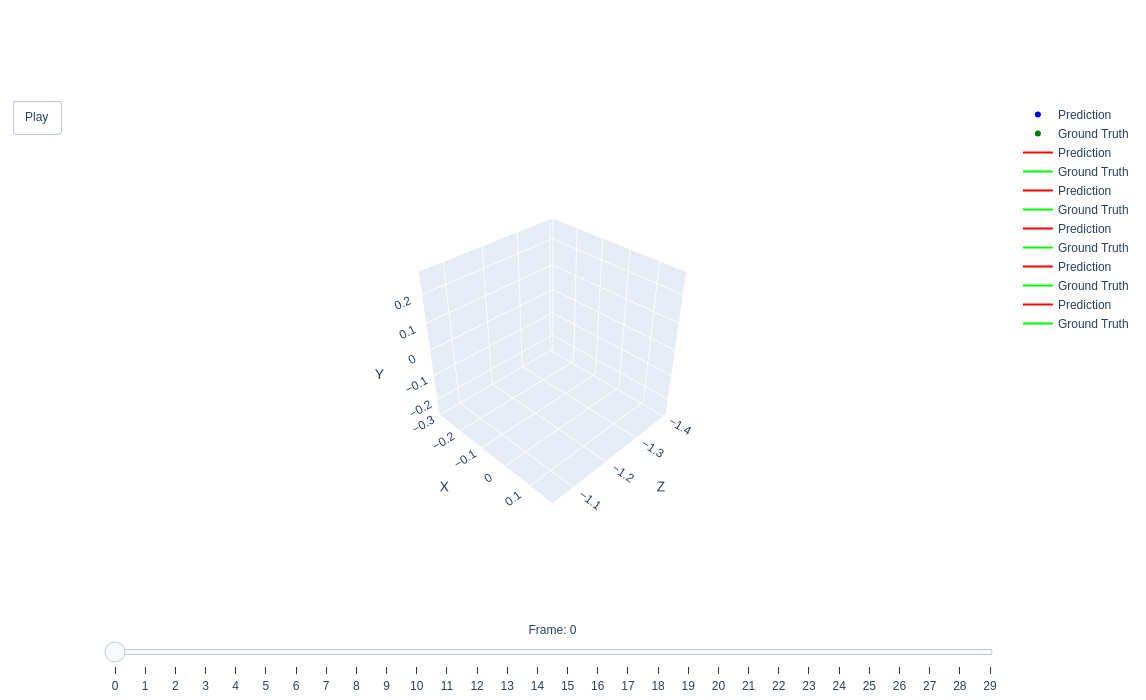

In [8]:
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interactive, IntSlider
from IPython.display import display

updated_connections = [
    (0, 1), (1, 2),  # Right arm
    (3, 4), (4, 5),  # Left arm
    (2, 3),  # Connection between arms
]

def update_plot(pred):
    # First dataset processing
    data = hf.reverse_normalization(predicted_positions[pred], medians_pos, iqrs_pos)
    #data = predicted_positions[pred]


    if len(data.shape) == 1:
        print("Data is a scalar or has unexpected shape.")
        return np.zeros((1, 3)), [], np.zeros((1, 3)), []
    else:
        valid_keypoints = ~np.isnan(data[:, :3]).any(axis=1)
        filtered_data = data[valid_keypoints]

        # Create mapping from old indices to new indices after NaN removal
        index_mapping = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints)[0])}
        # Create new connections for the first dataset
        new_connections = [(index_mapping[start], index_mapping[end])
                           for start, end in updated_connections
                           if start in index_mapping and end in index_mapping]

    # Second dataset processing
    data_y = hf.reverse_normalization(combined_Y_pos[batchnum][pred], medians_pos, iqrs_pos)
    #data_y = combined_Y_pos[batchnum][pred]


    if len(data_y.shape) == 1:
        print("Data_y is a scalar or has unexpected shape.")
        return np.zeros((1, 3)), [], np.zeros((1, 3)), []
    else:
        valid_keypoints_y = ~np.isnan(data_y[:, :3]).any(axis=1)
        filtered_data_y = data_y[valid_keypoints_y]

        # Create mapping from old indices to new indices for the second dataset
        index_mapping_y = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints_y)[0])}
        # Create new connections for the second dataset
        new_connections_y = [(index_mapping_y[start], index_mapping_y[end])
                             for start, end in updated_connections
                             if start in index_mapping_y and end in index_mapping_y]

    return filtered_data, new_connections, filtered_data_y, new_connections_y

# Calculate overall axis limits
# all_data = np.vstack([hf.reverse_normalization(pos, medians_pos, iqrs_pos) for pos in predicted_positions] +
#                      [hf.reverse_normalization(combined_Y_pos[batchnum][i], medians_pos, iqrs_pos) for i in range(len(predicted_positions))])

all_data = np.vstack([hf.reverse_normalization(pos, medians_pos, iqrs_pos) for pos in predicted_positions] +
                     [hf.reverse_normalization(combined_Y_pos[batchnum][i], medians_pos, iqrs_pos) for i in range(len(predicted_positions))])

# Ensure all_data is 3D
if all_data.ndim < 3:
    print(f"Warning: all_data has unexpected shape: {all_data.shape}")
    all_data = all_data.reshape(-1, 1, 3)  # Reshape to 3D

# Calculate min and max values for each axis
x_min, y_min, z_min = np.nanmin(all_data, axis=(0, 1))
x_max, y_max, z_max = np.nanmax(all_data, axis=(0, 1))

# Check if any of the values are NaN and replace with default values if necessary
if np.isnan(x_min) or np.isnan(x_max):
    print("Warning: X-axis limits contain NaN. Using default values.")
    x_min, x_max = -1, 1
if np.isnan(y_min) or np.isnan(y_max):
    print("Warning: Y-axis limits contain NaN. Using default values.")
    y_min, y_max = -1, 1
if np.isnan(z_min) or np.isnan(z_max):
    print("Warning: Z-axis limits contain NaN. Using default values.")
    z_min, z_max = -1, 1

# Add padding
padding = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
z_range = z_max - z_min
x_min -= x_range * padding
x_max += x_range * padding
y_min -= y_range * padding
y_max += y_range * padding
z_min -= z_range * padding
z_max += z_range * padding

# Initialize the plot
fig = go.Figure()

# Add initial traces (these will be updated later)
scatter = fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(size=6, color='blue'), name='Prediction'))
scatter_y = fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(size=6, color='green'), name='Ground Truth'))

for _ in range(len(updated_connections)):
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='red', width=2), name='Prediction'))
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='lime', width=2), name='Ground Truth'))

# Set layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', range=[x_min, x_max], autorange=False),
        yaxis=dict(title='Y', range=[y_min, y_max], autorange=False),
        zaxis=dict(title='Z', range=[z_min, z_max], autorange=False),
        aspectmode='cube',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5),  # Adjust camera position
                up=dict(x=0, y=1, z=0)  # Set up direction to positive z-axis
        )
    ),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(label='Play',
                      method='animate',
                      args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True, mode='immediate')])]
    )],
    height=700,
    width=700
)

# Create frames for animation
frames = []
for pred in range(len(predicted_positions)):
    filtered_data, new_connections, filtered_data_y, new_connections_y = update_plot(pred)
    
    frame = go.Frame(
        data=[
            go.Scatter3d(x=filtered_data[:, 0], y=filtered_data[:, 1], z=filtered_data[:, 2], mode='markers', marker=dict(size=6, color='blue')),
            go.Scatter3d(x=filtered_data_y[:, 0], y=filtered_data_y[:, 1], z=filtered_data_y[:, 2], mode='markers', marker=dict(size=6, color='green'))
        ] +
        [go.Scatter3d(x=[filtered_data[start, 0], filtered_data[end, 0]], 
                      y=[filtered_data[start, 1], filtered_data[end, 1]], 
                      z=[filtered_data[start, 2], filtered_data[end, 2]], 
                      mode='lines', line=dict(color='red', width=2))
         for start, end in new_connections] +
        [go.Scatter3d(x=[filtered_data_y[start, 0], filtered_data_y[end, 0]], 
                      y=[filtered_data_y[start, 1], filtered_data_y[end, 1]], 
                      z=[filtered_data_y[start, 2], filtered_data_y[end, 2]], 
                      mode='lines', line=dict(color='lime', width=2))
         for start, end in new_connections_y],
        name=str(pred)
    )
    frames.append(frame)

fig.frames = frames

# Add slider
sliders = [dict(
    steps=[dict(method='animate',
                args=[[str(i)], dict(mode='immediate', frame=dict(duration=500, redraw=True), transition=dict(duration=0))],
                label=str(i)) for i in range(len(predicted_positions))],
    transition=dict(duration=0),
    x=0,
    y=0, 
    currentvalue=dict(font=dict(size=12), prefix='Frame: ', visible=True, xanchor='center'),
    len=1.0
)]

fig.update_layout(sliders=sliders)

# Show the figure
fig.show()

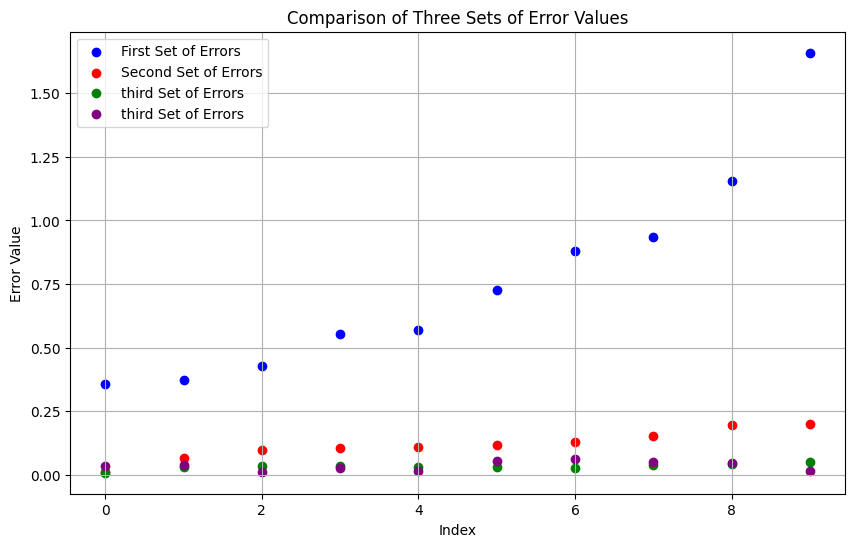

In [7]:
import matplotlib.pyplot as plt

# First set of error values
errors_first_set = [
    0.3571, 0.3716, 0.4279, 0.5543, 0.5699, 0.7271,
    0.8781, 0.9333, 1.1531, 1.6589
]

# Second set of error values
errors_second_set = [
    0.0135, 0.0668, 0.0971, 0.1059, 0.1099, 0.1166,
    0.1282, 0.1546, 0.1960, 0.1988
]

errors_third_set = [
    0.0090, 0.0329, 0.0358, 0.0358, 0.0330, 0.0299,
    0.0287, 0.0387, 0.0435, 0.0504
]

errors_new_Set = [0.0339,0.0396,0.0135,0.0280,0.0144,0.0545,0.0617,0.0530,0.0487,0.0139]


# Generate x values for plotting
x_values_first = list(range(len(errors_first_set)))
x_values_second = list(range(len(errors_second_set)))
x_values_third = list(range(len(errors_third_set)))
x_values_fourth= list(range(len(errors_new_Set)))

# Create the scatter plot
plt.figure(figsize=(10, 6))

plt.scatter(x_values_first, errors_first_set, color='blue', label='First Set of Errors')
plt.scatter(x_values_second, errors_second_set, color='red', label='Second Set of Errors')
plt.scatter(x_values_third, errors_third_set, color='green', label='third Set of Errors')
plt.scatter(x_values_fourth, errors_new_Set, color='purple', label='third Set of Errors')

plt.xlabel('Index')
plt.ylabel('Error Value')
plt.title('Comparison of Three Sets of Error Values')
plt.legend()
plt.grid(True)
plt.show()
